In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#first, let's load the train data

In [3]:
train_data = pd.read_csv("train.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId is of course redundant here, so it can be dropped right away.  
Also, let's extract the target vector. Name is probably not important for classification as well.

In [5]:
train_target = train_data["Survived"]

train_data.drop(["PassengerId", "Name"], axis=1, inplace=True)

In [6]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


Some Age values are null, and some Cabin values are also null. Embarked is also null for a few entries.

Let's first see how age affects survival for each sex group.

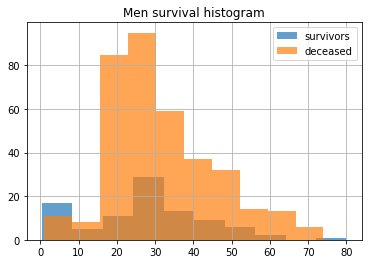

In [8]:
train_data[(train_data["Sex"] == "male") & (train_data["Survived"] == 1)]["Age"].hist(alpha=0.7, label="survivors")
train_data[(train_data["Sex"] == "male") & (train_data["Survived"] == 0)]["Age"].hist(alpha=0.7, label="deceased")
plt.legend()
plt.title("Men survival histogram")
plt.show()

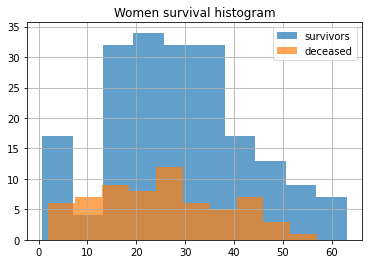

In [9]:
train_data[(train_data["Sex"] == "female") & (train_data["Survived"] == 1)]["Age"].hist(alpha=0.7, label="survivors")
train_data[(train_data["Sex"] == "female") & (train_data["Survived"] == 0)]["Age"].hist(alpha=0.7, label="deceased")
plt.legend()
plt.title("Women survival histogram")
plt.show()

It is clear, that women generally had a higher chance of survival. What's interesting is, that older women also tend to survive, whereas for males such a trend isn't obvious.

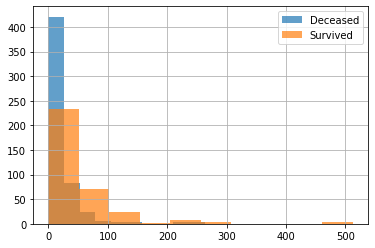

In [10]:
def plotClass(data, class_name):
    data.groupby("Survived", sort=False)[class_name].hist(alpha = 0.7)
    plt.legend(["Deceased", "Survived"])
    plt.show()

plotClass(train_data, "Fare")

Also, generally, people who paid more, were more likely to survive, as can be seen with this histogram.

Embarkation, as a guess, doesn't Surival much, but let's see if it is true.

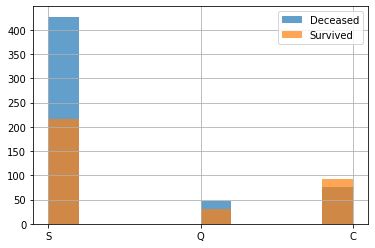

In [11]:
plotClass(train_data, "Embarked")

Surprising results here! People, who embarked at Southampton, were more less likely to survive!

Ticket class is probably closely related to the fare, so higher survival chance is possible for better ticket class. Let's see if it is indeed true.

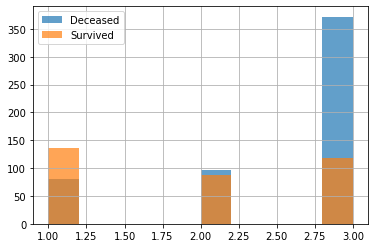

In [12]:
plotClass(train_data, "Pclass")

Exactly, first-class passengers were more likely to survive, in comparison with third-class passengers.

Let's see if SibSp and Parch attributes contain any information.

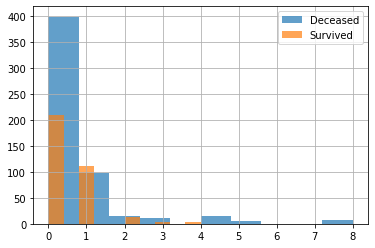

In [13]:
plotClass(train_data, "SibSp")

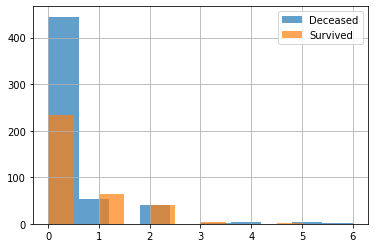

In [14]:
plotClass(train_data, "Parch")

There are indeed some differences between classes, but they cannot be described by a simple relation. I would like to see however, how a difference of Parch and SibSp compares with survival.

In [227]:
train_data["Care"] = train_data["SibSp"]-train_data["Parch"]

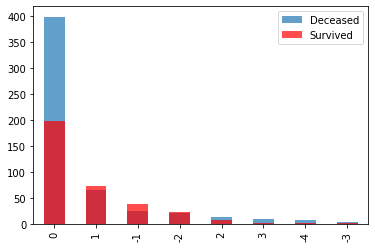

In [229]:
def plotLabel(data, label):
    data[data["Survived"] == 0][label].value_counts().plot.bar(alpha=0.7, label="Deceased")
    data[data["Survived"] == 1][label].value_counts().plot.bar(alpha=0.7, label="Survived", color="red")
    plt.legend()
    plt.show()

plotLabel(train_data, "Care")

Now the pattern is a bit more apparent, survivors were mostly passengers with "Care" nonzero, and those with high or low "Care" were a bit less lucky.

Now to the tickets and cabins.

In [17]:
train_data["Ticket"].value_counts()

CA. 2343              7
1601                  7
347082                7
CA 2144               6
3101295               6
                     ..
A/5. 3337             1
C 7075                1
349245                1
SOTON/O.Q. 3101311    1
111320                1
Name: Ticket, Length: 681, dtype: int64

There are some single values here, but some of them might be important. Conceretly, I would like to separate any letters in the ticket number, and count number of digits in it, since this information might be important (higher digit might mean a passenger embarked later than one with a lower number).

In [18]:
def ticket_process(ticket_id):
    #search for possible text occurences
    l = len(ticket_id)
    dig = ""
    s_idx = -1
    e_idx = -1
    for i in range(l):
        if not ticket_id[i].isdigit() and ticket_id[i] != ' ' and s_idx == -1:
            s_idx = i
        elif ticket_id[i].isdigit():
            dig += ticket_id[i]
            if e_idx == -1:
                e_idx = i
        elif ticket_id[i] == ' ':
            if e_idx == -1:
                e_idx = i
    if s_idx != -1 and e_idx == -1:
        e_idx = l
    if s_idx != -1:
        text = ticket_id[s_idx:e_idx]
    else:
        text = ""
    if len(dig):
        dig = int(dig)
    else:
        dig = 0
    return [text, dig]

ticket_process("CA. 2343")

['CA.', 2343]

Works. Let's now see if labels are of any importance when it comes to survival. I will remove the less frequent labels.

In [19]:
train_data[["TicketLabel", "TicketNo"]] = train_data["Ticket"].apply(ticket_process).tolist()

In [20]:
size_transform = train_data.groupby("TicketLabel")["TicketLabel"].transform("size")
train_data.loc[size_transform < 8, "TicketLabel"] = ""
train_data["TicketLabel"].value_counts()

              738
PC             60
C.A.           27
A/             23
STON/O         18
W./C.           9
SOTON/O.Q.      8
CA.             8
Name: TicketLabel, dtype: int64

Not many options here, but let's see if is correlated with survival.

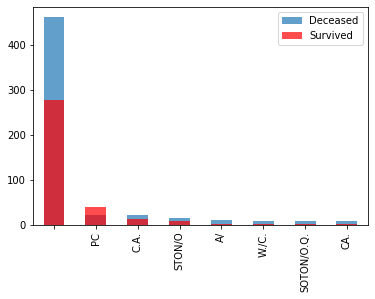

In [21]:
plotLabel(train_data, "TicketLabel")

There seem to be some differences between classes, some with higer survival rate, some with lower, so I will keep the transformation.

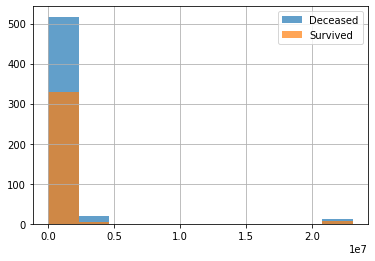

In [22]:
plotClass(train_data, "TicketNo")

Not much information here, I will later decide if it is helpful. Let's now get to the cabins.

In [23]:
def cabin_process(cabin):
    if pd.isnull(cabin):
        return ["", 0]
    i = 0
    letter = ""
    while i < len(cabin) and not cabin[i].isdigit() and cabin[i] != ' ':
        letter += cabin[i]
        i += 1
    number = ""
    while i < len(cabin) and cabin[i].isdigit():
        number += cabin[i]
        i += 1
    if not number:
        number = 0
    else:
        number = int(number)
    return [str(letter), number]  


In [24]:
train_data[["CabinLabel", "CabinIndex"]] = train_data["Cabin"].apply(cabin_process).tolist()

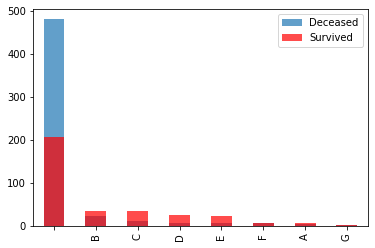

In [25]:
plotLabel(train_data, "CabinLabel")

Again, some differences can be seen, generally people with a cabin assigned survived.

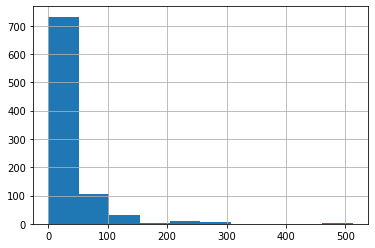

In [202]:
train_data["Fare"].hist()
plt.show()

As can be seen, Fare could benefit from a log transform.

Let's now build a classifier on top of what I have. 

For the ticket class I won't be using encoding, since there is an order in the real world data. When it comes to age and embarkement place, I will just use the median.

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class CabinTransformer(BaseEstimator, TransformerMixin):
    
    def __process(self, X, dropRare = False):
        xfl = X.to_numpy().flatten()
        out = [None] * len(X)
        counts = {}
        for i in range(len(X)):
            out[i] = cabin_process(xfl[i])
        for en in out:
            lab = en[0]
            counts[lab] = counts.get(lab, 0) + 1
        for en in out:
            if counts[en[0]] < self.minN:
                en[0] = ""
        return np.matrix(out)
            
    
    def __init__(self, encoder = OneHotEncoder(handle_unknown="ignore"), minN = 10):
        self.minN = 10
        self.encoder = encoder
    
    def fit(self, X, y = None):
        xout = self.__process(X, dropRare = True)
        self.encoder.fit(xout[:,0])
        return self
    
    def transform(self, X):
        xout = self.__process(X)
        return np.concatenate([self.encoder.transform(xout[:,0]).toarray(), np.matrix(xout[:,1])], axis=1)
    

class TicketTransformer(BaseEstimator, TransformerMixin):
    
    def __process(self, X, dropRare = False):
        xfl = X.to_numpy().flatten()
        out = [None] * len(X)
        counts = {}
        for i in range(len(X)):
            out[i] = ticket_process(xfl[i])
        for en in out:
            lab = en[0]
            counts[lab] = counts.get(lab, 0) + 1
        for en in out:
            if counts[en[0]] < self.minN:
                en[0] = ""
        return np.matrix(out)
    
    def __init__(self, encoder = OneHotEncoder(handle_unknown="ignore"), minN = 10):
        self.encoder = encoder
        self.minN = minN
        
    def fit(self, X, y = None):
        xout = self.__process(X, dropRare = True)
        self.encoder.fit(xout[:,0])
        return self

    def transform(self, X):
        xout = self.__process(X)
        return np.concatenate([self.encoder.transform(xout[:,0]).toarray(), np.matrix(xout[:,1])], axis=1)

In [240]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

class IdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self): pass
    def fit(self, X, y = None): return self
    def transform(self, X): return X

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

fare_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("logTransform", FunctionTransformer(np.log1p)),
    ("scaler", StandardScaler())
])

main_transformer = ColumnTransformer([
    ("cabinTransformer", CabinTransformer(), ["Cabin"]),
    ("ticketTransformer", TicketTransformer(), ["Ticket"]),
    ("simpleOneHot", OneHotEncoder(handle_unknown="ignore"), ["Embarked", "Sex"]),
    ("simpleNumeric", numeric_transformer, ["Age", "SibSp", "Parch", "Care"]),
    ("fareNumeric", fare_transformer, ["Fare"]),
    ("ticketClass", IdTransformer(), ["Pclass"])
])

class AdderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, main_pipeline):
        self.main_pipeline = main_pipeline
    
    def fit(self, X):
        xcp = X.copy()
        xcp["Care"] = xcp["SibSp"] - xcp["Parch"]
        self.main_pipeline.fit(xcp)
        return self
    
    def transform(self, X):
        xcp = X.copy()
        xcp["Care"] = xcp["SibSp"] - xcp["Parch"]
        return self.main_pipeline.transform(xcp).astype(float)

         

In [241]:
train_data = pd.read_csv("train.csv")
X_train = train_data.drop(["PassengerId", "Name", "Survived"], axis=1)

In [242]:
full_pipeline = AdderTransformer(main_transformer)

full_pipeline.fit(X_train)

AdderTransformer(main_pipeline=ColumnTransformer(transformers=[('cabinTransformer',
                                                                CabinTransformer(),
                                                                ['Cabin']),
                                                               ('ticketTransformer',
                                                                TicketTransformer(),
                                                                ['Ticket']),
                                                               ('simpleOneHot',
                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                ['Embarked',
                                                                 'Sex']),
                                                               ('simpleNumeric',
                                                                Pipeline(steps=[('imputer',
 

In [244]:
full_pipeline.transform(X_train).shape

(891, 26)

Let's explore some classifiers now.

In [245]:
y_train = train_data["Survived"]

In [246]:
X_train_ready = full_pipeline.fit_transform(X_train).astype(float)

In [247]:
X_train_ready.shape

(891, 26)

Try out different models.

In [248]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_params = {
    "C" : np.logspace(-25, 10, 10),
    "kernel" : ["rbf"]
}

svc = SVC()

search_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=8,
                     scoring="accuracy", verbose = 2)

In [249]:
search_svc.fit(X_train_ready, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=8,
             param_grid={'C': array([1.00000000e-25, 7.74263683e-22, 5.99484250e-18, 4.64158883e-14,
       3.59381366e-10, 2.78255940e-06, 2.15443469e-02, 1.66810054e+02,
       1.29154967e+06, 1.00000000e+10]),
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [250]:
search_svc.best_estimator_

SVC(C=1e-25)

In [251]:
search_svc.best_score_

0.6161616161616161

In [252]:
from sklearn.ensemble import RandomForestClassifier

In [253]:
rfc = RandomForestClassifier()

rfc_params = {
    "n_estimators" : np.linspace(10, 100, 10, dtype = int),
    "max_depth" : np.linspace(10, 100, 10, dtype = int),
    "min_samples_split" : [2, 3, 4, 5]
}

search_rfc = GridSearchCV(rfc, rfc_params, cv=3, n_jobs=8, 
                         scoring="accuracy", verbose = 1)

In [254]:
search_rfc.fit(X_train_ready, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='accuracy', verbose=1)

In [255]:
search_rfc.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=90)

In [256]:
search_rfc.best_score_

0.8361391694725029

In [257]:
from sklearn.neighbors import KNeighborsClassifier

In [258]:
knn = KNeighborsClassifier()

knn_params = {
    "n_neighbors" : np.linspace(1, 30, 20, dtype=int)  
}

knn_search = GridSearchCV(knn, knn_params, cv=3, scoring="accuracy",
                         verbose = 2, n_jobs = 8)

In [259]:
knn_search.fit(X_train_ready, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid={'n_neighbors': array([ 1,  2,  4,  5,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25,
       26, 28, 30])},
             scoring='accuracy', verbose=2)

In [260]:
knn_search.best_estimator_

KNeighborsClassifier(n_neighbors=19)

In [261]:
knn_search.best_score_

0.6846240179573512

In [280]:
rfc = RandomForestClassifier()

rfc_params = {
    "n_estimators" : np.linspace(80, 120, 20, dtype = int),
    "max_depth" : [None],
    "min_samples_split" : [2,3,4,5,6,7,8,9,10,11]
}

search_rfc = GridSearchCV(rfc, rfc_params, cv=3, n_jobs=8, 
                         scoring="accuracy", verbose = 1)

In [281]:
search_rfc.fit(X_train_ready, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [None],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'n_estimators': array([ 80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 120])},
             scoring='accuracy', verbose=1)

In [282]:
search_rfc.best_estimator_

RandomForestClassifier(min_samples_split=6, n_estimators=90)

In [283]:
search_rfc.best_score_

0.8327721661054994

Let's try to evaluate now.

In [266]:
best_estimator = search_rfc.best_estimator_

In [267]:
best_estimator.fit(X_train_ready, y_train)

RandomForestClassifier(max_depth=93, min_samples_split=4, n_estimators=82)

In [268]:
test_data = pd.read_csv("test.csv")

In [269]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [270]:
X_test = test_data.drop(["PassengerId", "Name"], axis=1)
label_test = test_data["PassengerId"]

In [271]:
X_test_ready = full_pipeline.transform(X_test).astype(float)

In [272]:
y_pred = best_estimator.predict(X_test_ready)

In [273]:
d = {'PassengerId': label_test, 'Survived': y_pred}
result = pd.DataFrame(data=d)

In [274]:
result.to_csv("result2.csv", index=False)  #accuracy result was around 79%

In [157]:
from sklearn.neural_network import MLPClassifier

In [181]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 1000))

mlp_params = {
    "alpha" : np.logspace(-8, 0, 40),
    "hidden_layer_sizes" : [(100,), (100, 100), (100, 100, 100), (400, 400), (400, 400, 400), (500, 500, 500)]
}

mlp_search = GridSearchCV(mlp, mlp_params, scoring="accuracy",
                         cv=3, n_jobs=12, verbose = 1)

In [182]:
mlp_search.fit(X_train_ready, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3, estimator=MLPClassifier(hidden_layer_sizes=(1000, 1000)),
             n_jobs=12,
             param_grid={'alpha': array([1.00000000e-08, 1.60371874e-08, 2.57191381e-08, 4.12462638e-08,
       6.61474064e-08, 1.06081836e-07, 1.70125428e-07, 2.72833338e-07,
       4.37547938e-07, 7.01703829e-07, 1.12533558e-06, 1.80472177e-06,
       2.89426612e-06, 4.64158883e-06, 7.44380301e-06, 1.19377664e-05...
       8.37677640e-04, 1.34339933e-03, 2.15443469e-03, 3.45510729e-03,
       5.54102033e-03, 8.88623816e-03, 1.42510267e-02, 2.28546386e-02,
       3.66524124e-02, 5.87801607e-02, 9.42668455e-02, 1.51177507e-01,
       2.42446202e-01, 3.88815518e-01, 6.23550734e-01, 1.00000000e+00]),
                         'hidden_layer_sizes': [(100,), (100, 100),
                                                (100, 100, 100), (400, 400),
                                                (400, 400, 400),
                                                (500, 500, 500)]},
             sco

In [185]:
mlp_search.best_estimator_

MLPClassifier(alpha=2.7283333764867697e-07)

In [186]:
mlp_search.best_score_

0.6554433221099888